# **Обучение модели на физико-химических и топологических признаках + 5 различных наборов данных**

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
import optuna
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


In [2]:
data = pd.read_csv('result_features_no_fingerprint.csv')

In [3]:
target_col = 'score'


X = data.drop(columns=['score','SMILES'], axis=1)
y = data['score']

**Стандартизация фичей**

In [4]:
scaler = StandardScaler()


X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)


print("Средние значения после стандартизации (≈0):")
print(X_scaled.mean().round(3).head())

print("\nСтандартные отклонения после стандартизации (≈1):")
print(X_scaled.std().round(3).head())

Средние значения после стандартизации (≈0):
MW_EXACT   -0.0
XLogP       0.0
HBA        -0.0
HBD        -0.0
TPSA_NO     0.0
dtype: float64

Стандартные отклонения после стандартизации (≈1):
MW_EXACT    1.0
XLogP       1.0
HBA         1.0
HBD         1.0
TPSA_NO     1.0
dtype: float64


**Удаление коррелирующих признаков**

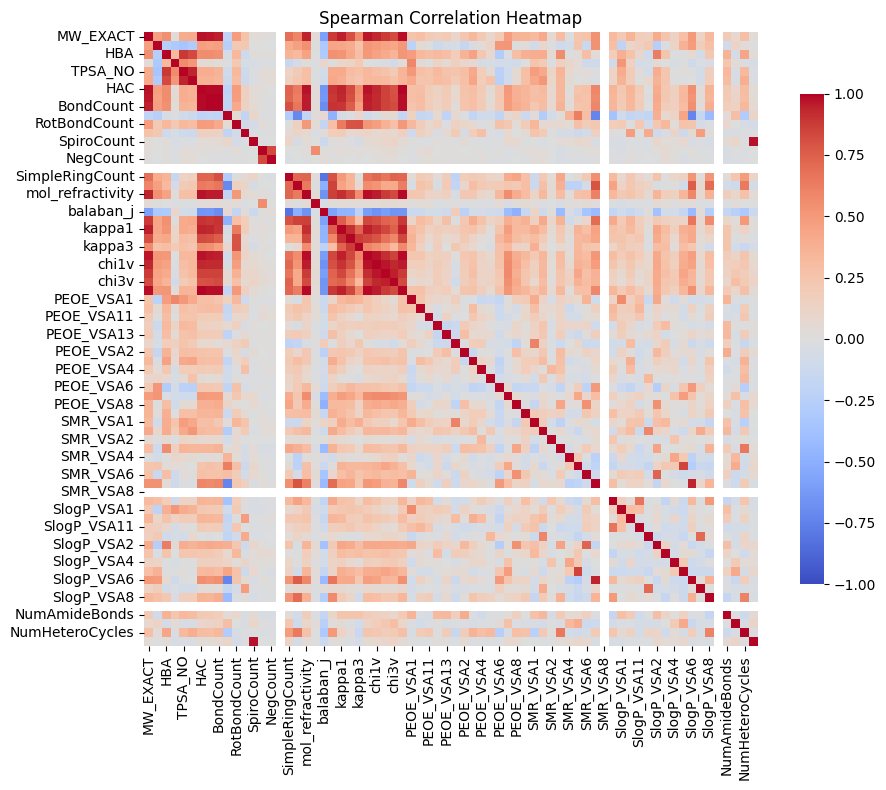

Оставшиеся признаки: ['MW_EXACT', 'XLogP', 'HBA', 'HBD', 'TPSA_NO', 'FSP3', 'RotBondCount', 'HalogenCount', 'SpiroCount', 'PosCount', 'NegCount', 'ComponentCount', 'SimpleRingCount', 'AromaticRingCount', 'formal_charge', 'balaban_j', 'kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'NumAmideBonds', 'NumAlifCarboxy', 'NumHeteroCycles']
Размер до: (89572, 70), после: (89572, 55)


In [5]:
X_spearman = X_scaled.copy()

corr_spearman = X_spearman.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spearman,
    annot=False,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

upper = corr_spearman.where(np.triu(np.ones(corr_spearman.shape), k=1).astype(bool))

# Список признаков с |corr| > 0.9
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.9)]

X_filtered = X_spearman.drop(columns=to_drop)

print("Оставшиеся признаки:", X_filtered.columns.tolist())
print(f"Размер до: {X_spearman.shape}, после: {X_filtered.shape}")

y_filtered = y.loc[X_filtered.index]

**Подбор полиномиальной степени**

In [16]:
train_rmse_errors = []
test_rmse_errors = []

for d in range (1,3):
    poly_converter = PolynomialFeatures(degree=d, include_bias=False)
    poly_data = poly_converter.fit_transform(X_filtered)

    

    X_train, X_test, y_train, y_test = train_test_split(poly_data, y_filtered, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
    
    train_rmse_errors.append(train_rmse)
    test_rmse_errors.append(test_rmse)

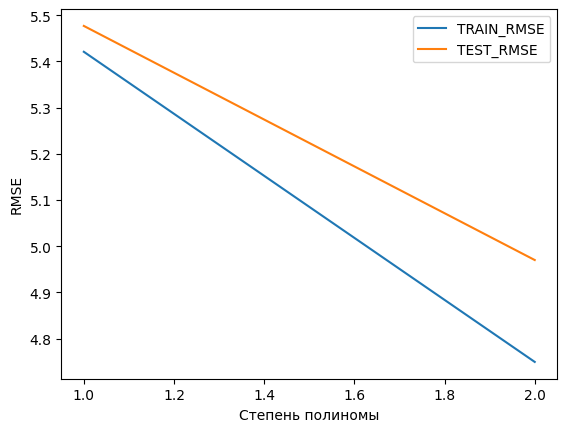

In [17]:
plt.plot(range(1,3),train_rmse_errors, label='TRAIN_RMSE')
plt.plot(range(1,3),test_rmse_errors, label='TEST_RMSE')

plt.xlabel('Степень полиномы')
plt.ylabel('RMSE')
plt.legend()


**Обучение и оценка LinearRegression**

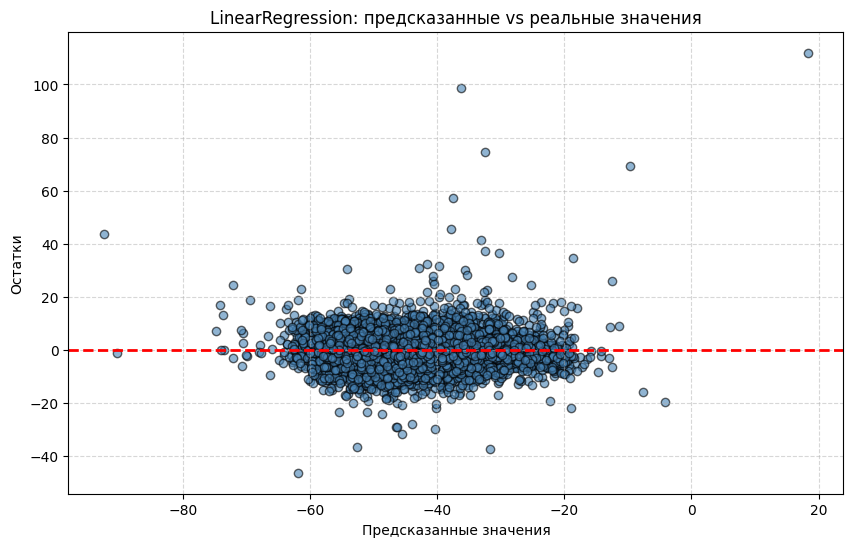

In [25]:
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_converter.fit_transform(X_filtered)

    

X_train, X_test, y_train, y_test = train_test_split(poly_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='steelblue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("LinearRegression: предсказанные vs реальные значения")
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

===== Результаты кросс-валидации =====
Средний R² : 0.706 ± 0.006
Средний RMSE: 5.405 ± 0.056
Средний MAE : 3.935 ± 0.017


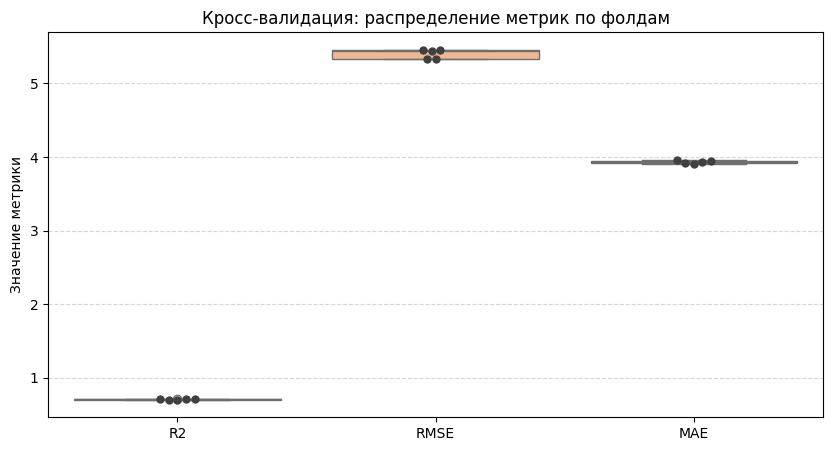

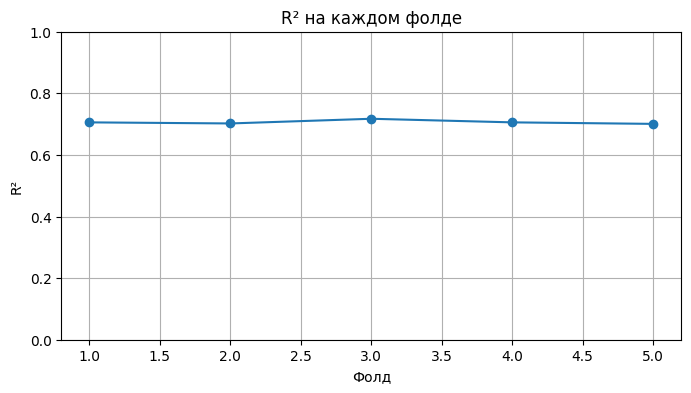

In [26]:
model = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

y_array = y.values.ravel()
r2_scores = cross_val_score(model, poly_data, y_array, cv=cv, scoring="r2")

rmse_scores = -cross_val_score(model, X, y_array, cv=cv,
                               scoring="neg_root_mean_squared_error")
# MAE
mae_scores = -cross_val_score(model, X, y_array, cv=cv,
                              scoring="neg_mean_absolute_error")

print("===== Результаты кросс-валидации =====")
print(f"Средний R² : {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"Средний RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
print(f"Средний MAE : {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")



metrics_df = pd.DataFrame({
    "R2":   r2_scores,
    "RMSE": rmse_scores,
    "MAE":  mae_scores
})

plt.figure(figsize=(10, 5))
sns.boxplot(data=metrics_df, palette="pastel")
sns.swarmplot(data=metrics_df, color=".25", size=6)  # точки каждого фолда
plt.title("Кросс-валидация: распределение метрик по фолдам")
plt.ylabel("Значение метрики")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, cv.n_splits + 1), r2_scores, marker='o')
plt.title("R² на каждом фолде")
plt.xlabel("Фолд")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid()
plt.show()